In [37]:
import sys
sys.path.append("../") # adding the path to read the utils file
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from xgboost import XGBClassifier
from sklearn import metrics, tree
from shap import TreeExplainer
import fasttreeshap
from shap import plots, Explanation
import graphviz 
from yellowbrick.model_selection import LearningCurve
import time
from utils import *
import pickle
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [38]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_hikari, usecols=selected_features_hikari),
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_hikari, usecols=selected_features_hikari)], 
    ignore_index=True)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [39]:

compute_ratio(ds,'traffic_category')

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


In [40]:
ds['traffic_category'] = np.where(ds['traffic_category'] == 'Background', 'Benign', ds['traffic_category'])

gbtree was choosen over dart because is faster and over the linear one because the linear one poorly perform

In [41]:
params = {
    "n_estimators": 3,
    "max_depth": 8,
    "learning_rate": 1, 
    "booster": 'gbtree', 
    "objective": 'multi:softprob',
    "n_jobs": -1,
    "random_state": 12,
    "num_class": 5
}

bst = XGBClassifier(**params)

le = LabelEncoder()
le.fit(ds['traffic_category'])

rus = RandomUnderSampler(random_state=42, sampling_strategy='all')
X_res, y_res = rus.fit_resample(ds[x_features], le.transform(ds['traffic_category']))

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state=12,  stratify=y_res)

In [43]:
if False:
    cv = 10
    visualizer = LearningCurve(estimator=bst, cv=cv, scoring='f1_weighted', n_jobs=1, random_state=123)
    visualizer.fit(X_res, y_res)
    visualizer.show(outpath="bst_data/learning_curve.png")

![Alt text](bst_data/learning_curve.png)

In [44]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X_res, y_res)

5

In [45]:
avg_train_f1 = []
avg_test_f1 = []

for i, (train_index, test_index) in enumerate(skf.split(X_res, y_res)):
    print(f"Fold {i}:")
    bst.fit(X_res.iloc[train_index], y_res[train_index])
    y_predicted_train = bst.predict(X_res.iloc[train_index])
    y_predicted_test = bst.predict(X_res.iloc[test_index])
    train_f1 = metrics.f1_score(y_res[train_index], y_predicted_train, average='weighted')
    test_f1 = metrics.f1_score(y_res[test_index], y_predicted_test, average='weighted')
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    avg_train_f1.append(train_f1)
    avg_test_f1.append(test_f1)

print(f"Average Train F1: {np.mean(avg_train_f1):.4f}")
print(f"Average Test F1: {np.mean(avg_test_f1):.4f}")

Fold 0:
Train F1: 0.9698
Test F1: 0.9643
Fold 1:
Train F1: 0.9697
Test F1: 0.9677
Fold 2:
Train F1: 0.9698
Test F1: 0.9646
Fold 3:
Train F1: 0.9687
Test F1: 0.9703
Fold 4:
Train F1: 0.9694
Test F1: 0.9673
Average Train F1: 0.9695
Average Test F1: 0.9668


In [82]:
%time bst.fit(X_train, y_train)

The slowest run took 4.49 times longer than the fastest. This could mean that an intermediate result is being cached.
283 ms ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [83]:
%time y_predicted_train = bst.predict(X_train)
%timeit y_predicted_test = bst.predict(X_test)

CPU times: user 148 ms, sys: 499 µs, total: 149 ms
Wall time: 21.9 ms
10.9 ms ± 4.22 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
# Function to create dataframe with metrics
def performanceMetricsDF(
    metricsObj, yTrain, yPredTrain, yTest, yPredTest, average="binary"
):
    measures_list = ["ACCURACY", "PRECISION", "RECALL", "F1 SCORE"]
    train_results = [
        metricsObj.accuracy_score(yTrain, yPredTrain),
        metricsObj.precision_score(yTrain, yPredTrain, average=average),
        metricsObj.recall_score(yTrain, yPredTrain, average=average),
        metricsObj.f1_score(yTrain, yPredTrain, average=average),
    ]
    test_results = [
        metricsObj.accuracy_score(yTest, yPredTest),
        metricsObj.precision_score(yTest, yPredTest, average=average),
        metricsObj.recall_score(yTest, yPredTest, average=average),
        metricsObj.f1_score(yTest, yPredTest, average=average),

    ]
    resultsDF = pd.DataFrame(
        {"Measure": measures_list, "Train": train_results, "Test": test_results}
    )
    return resultsDF

In [49]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test, 'weighted')

,Measure,Train,Test
0,ACCURACY,0.970737,0.966074
1,PRECISION,0.972318,0.967647
2,RECALL,0.970737,0.966074
3,F1 SCORE,0.970057,0.965166


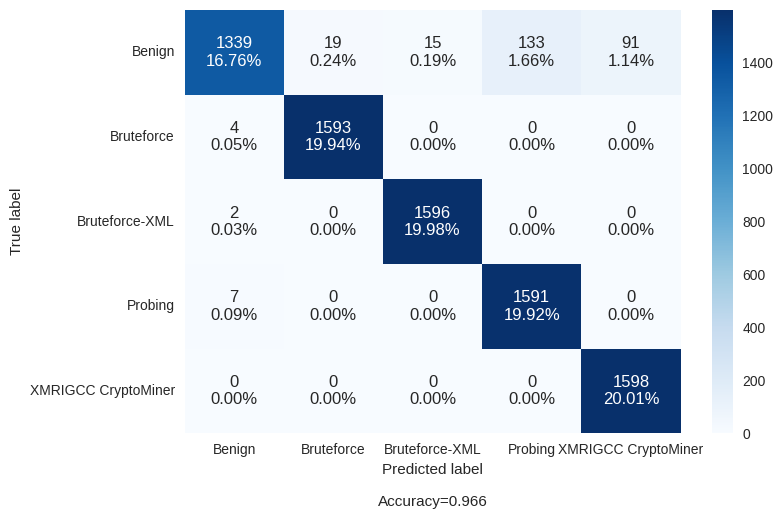

In [50]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(le.classes_)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [51]:
import xgboost as xgb

for tree_num in range(0,6):
    tree_viz = xgb.to_graphviz(bst, num_trees=0, rankdir='LR')
    tree_viz.render(f"bst_data/tree_{tree_num}")

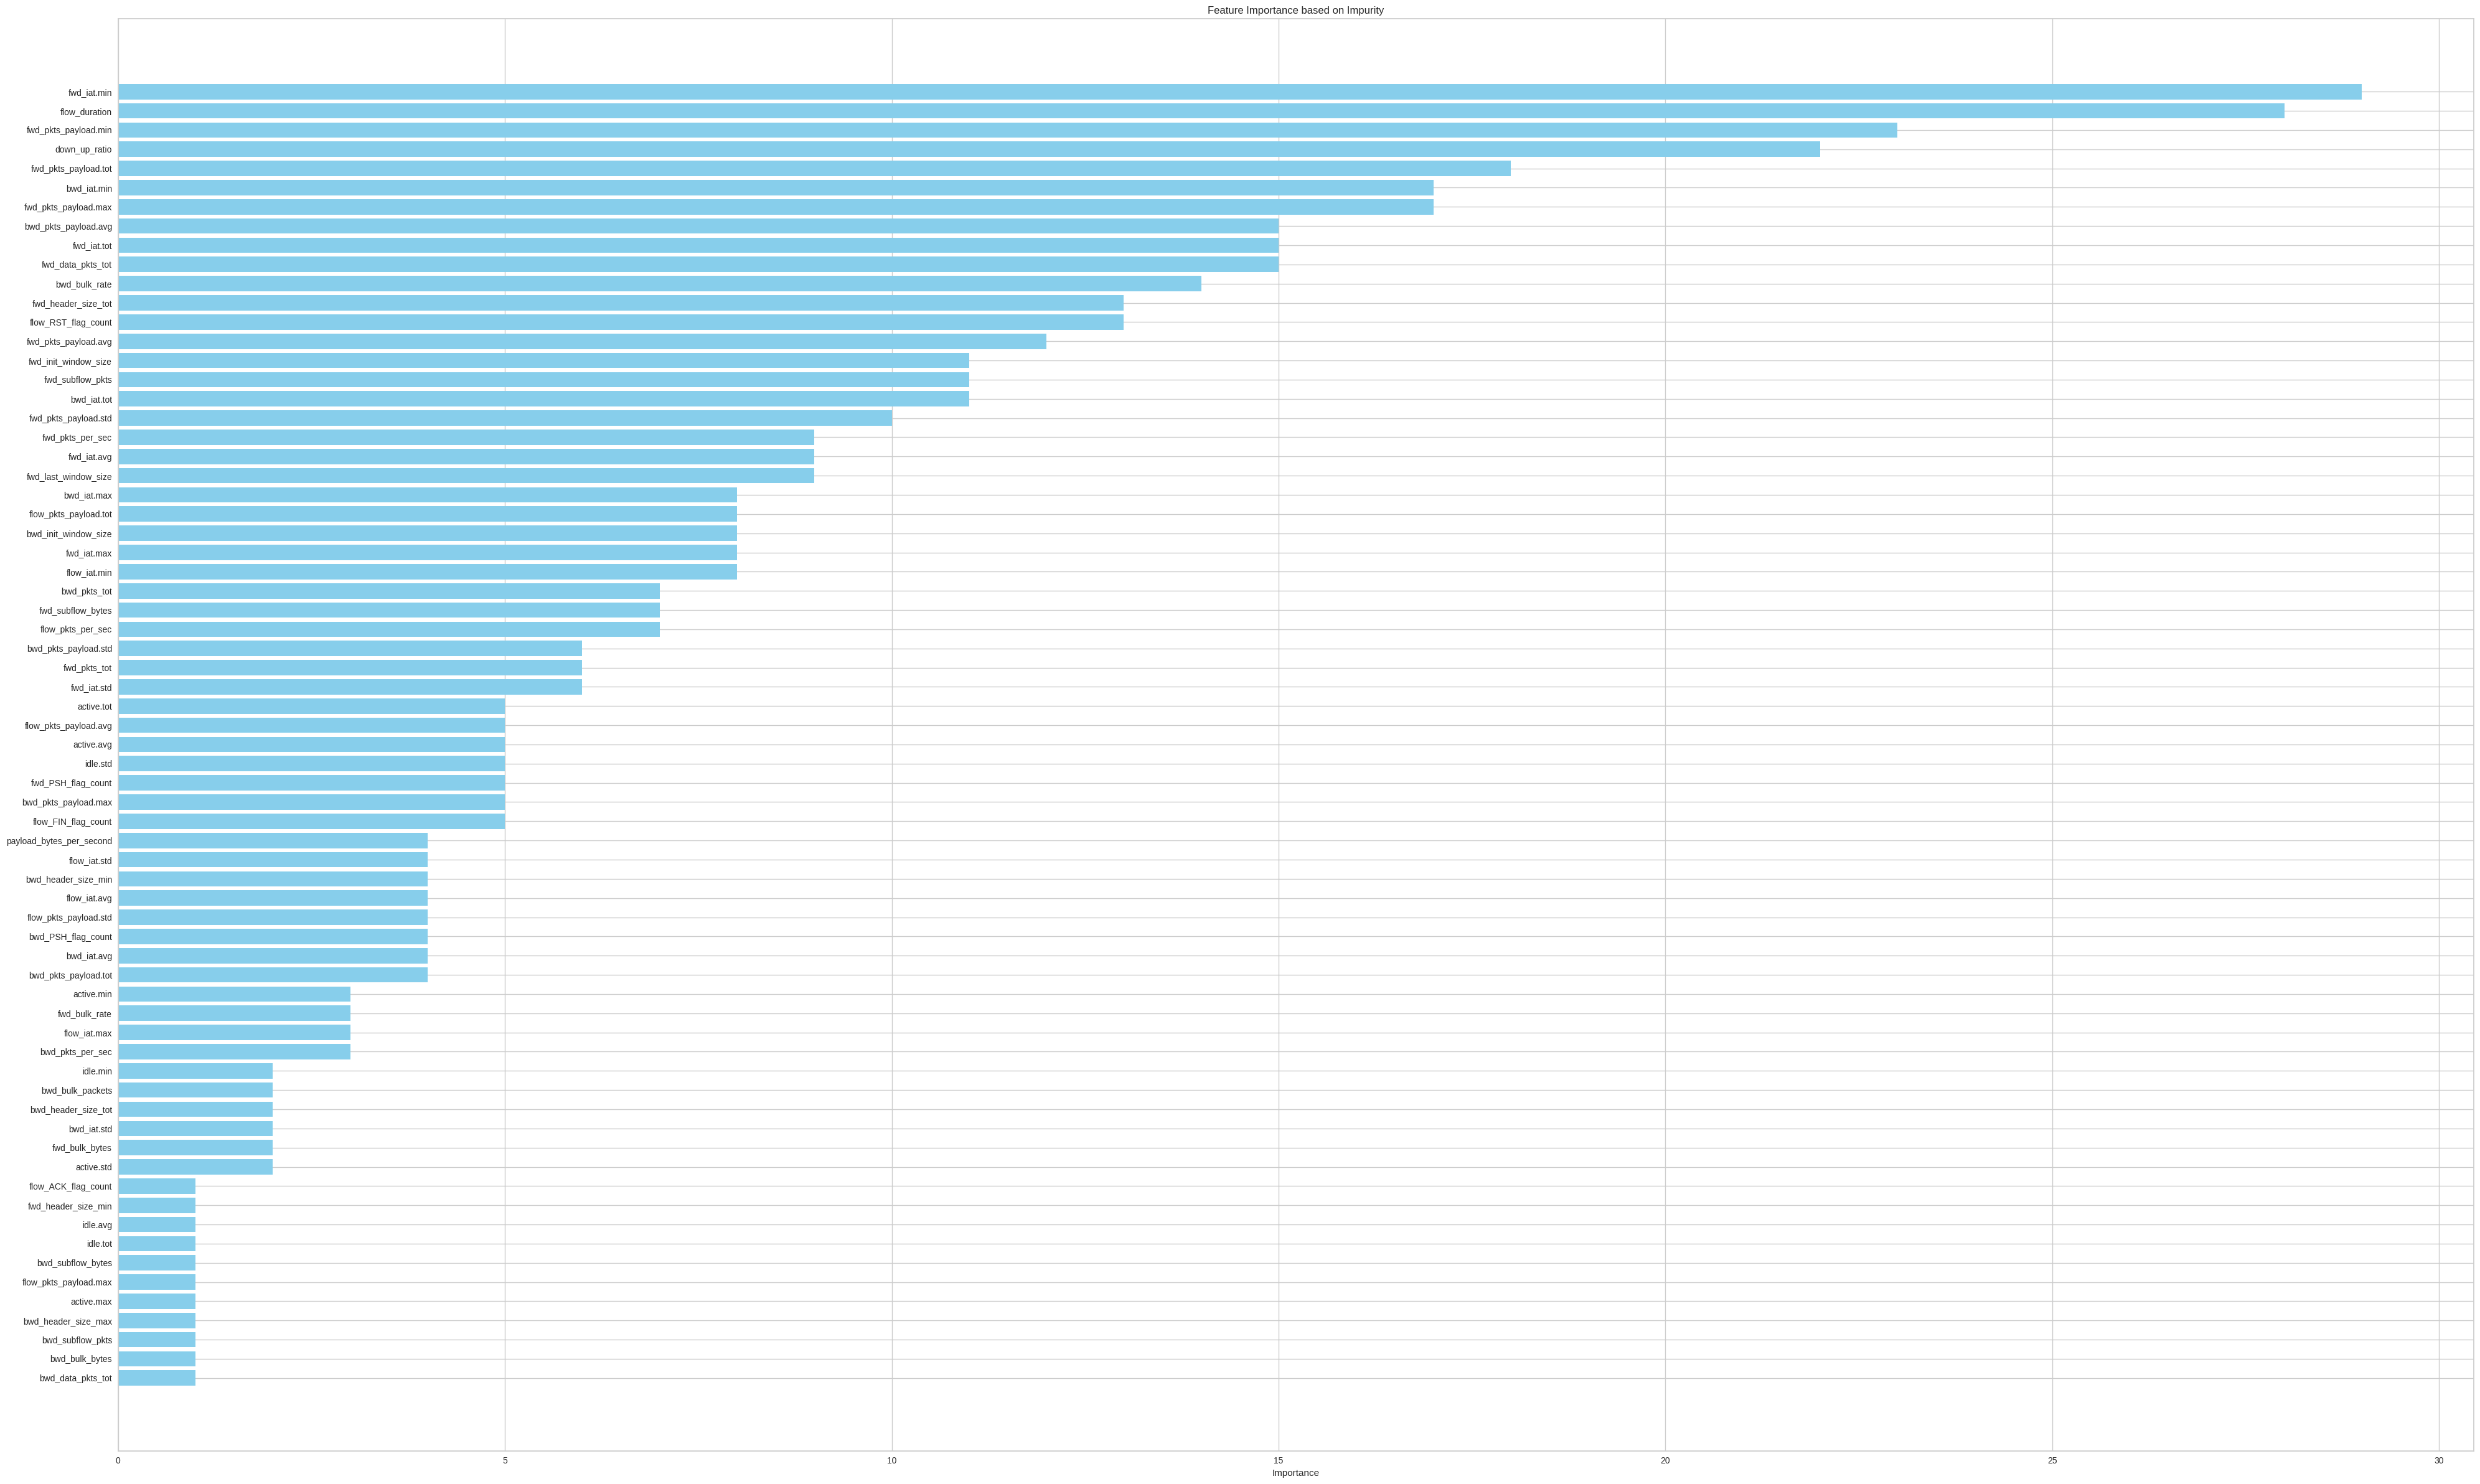

In [52]:
# Get feature importance based on impurity
impurity_importance = bst.get_booster().get_score(importance_type='weight')

# Convert the dictionary to a DataFrame
feature_importance_df = pd.DataFrame(list(impurity_importance.items()), columns=['Feature', 'Importance'])

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Reset index
feature_importance_df.reset_index(drop=True, inplace=True)

# Plotting feature importance
plt.figure(figsize=(40, 24))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance based on Impurity')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.tight_layout()
plt.show()

In [53]:
%%time

explainer = fasttreeshap.TreeExplainer(bst, X_train, algorithm='auto', n_jobs=-1, feature_perturbation="interventional")
sv = explainer(X_train)

[12:52:35] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 99%|===================| 158600/159760 [01:19<00:00]        

CPU times: user 1min 18s, sys: 315 ms, total: 1min 19s
Wall time: 1min 19s


## Benign shap

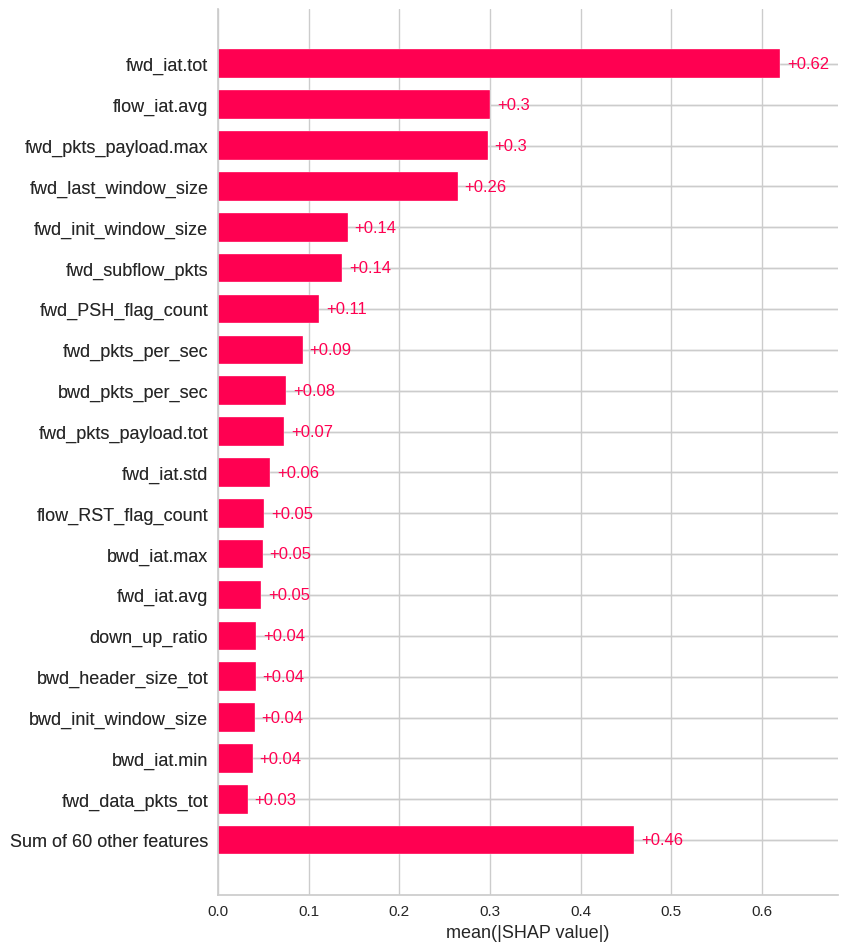

In [54]:
exp = Explanation(sv.values[:,:,0], 
                  sv.base_values[:,0], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

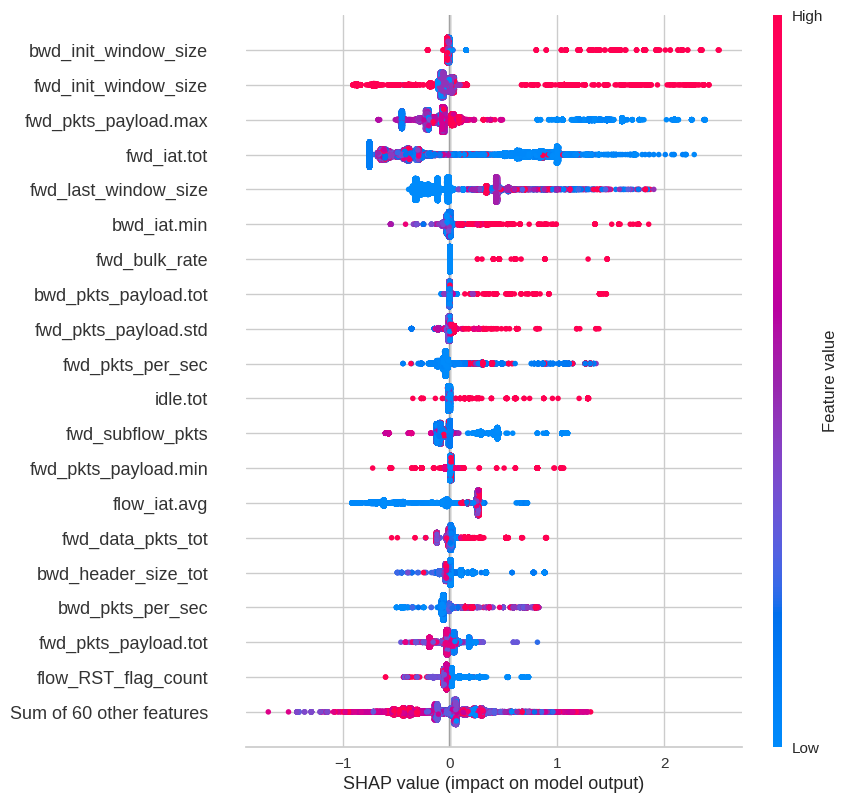

In [55]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

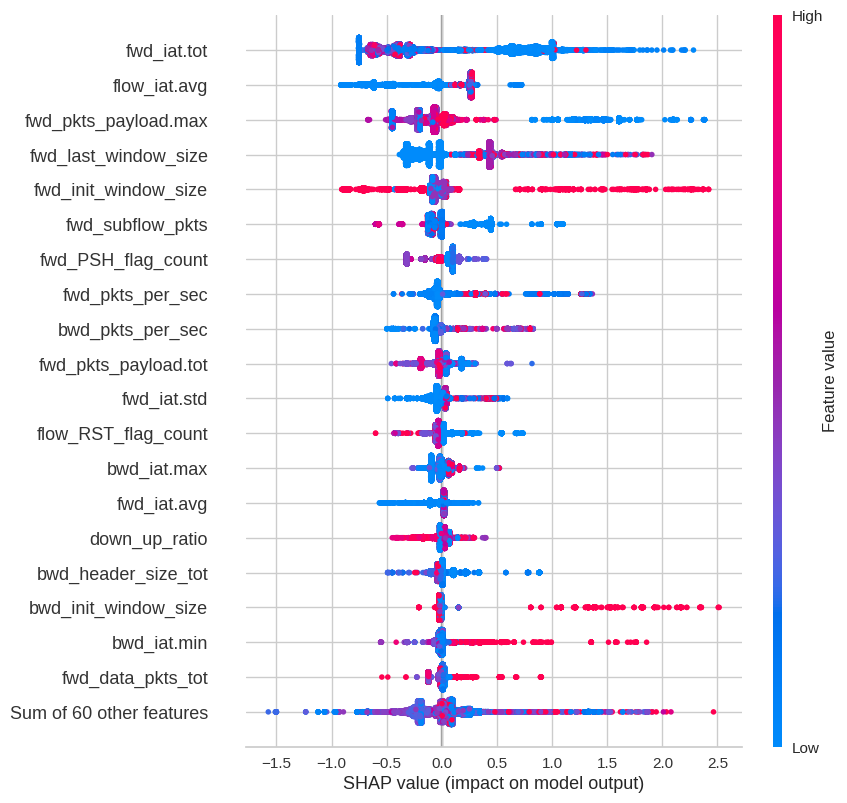

In [56]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bruteforce shap

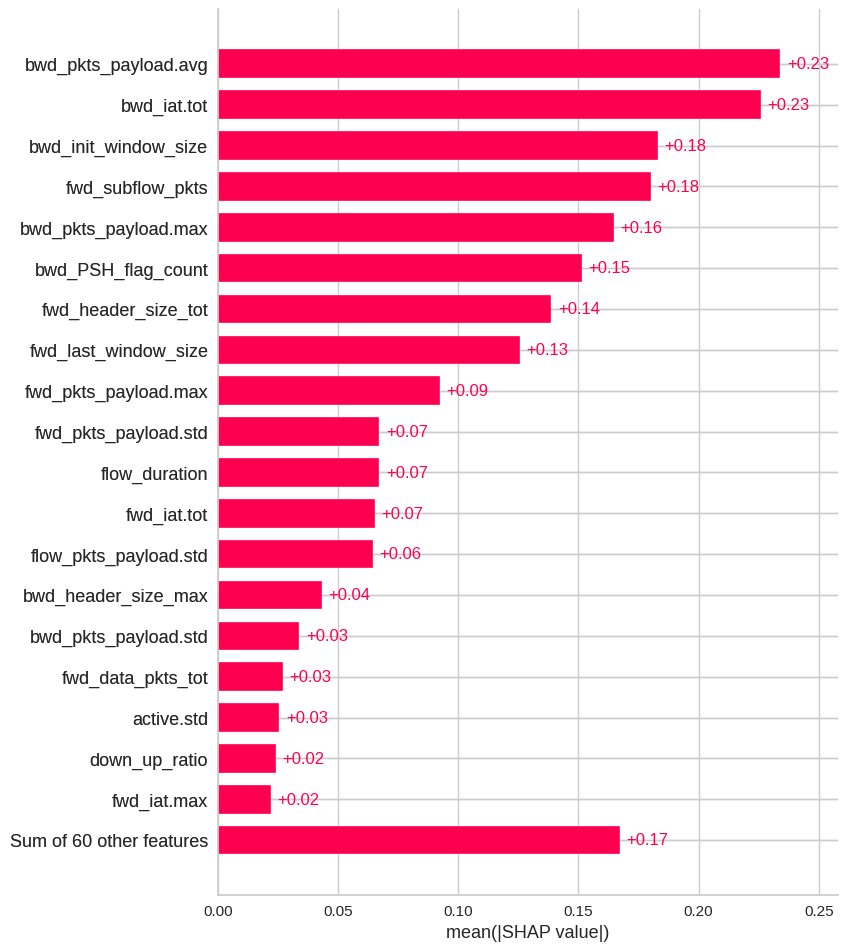

In [57]:
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

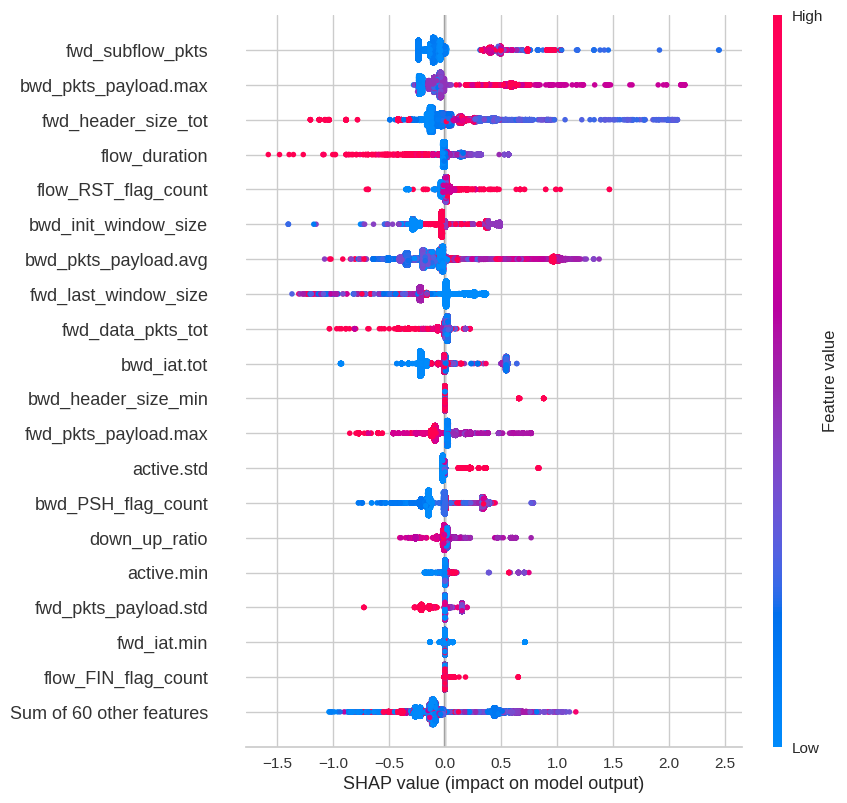

In [58]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

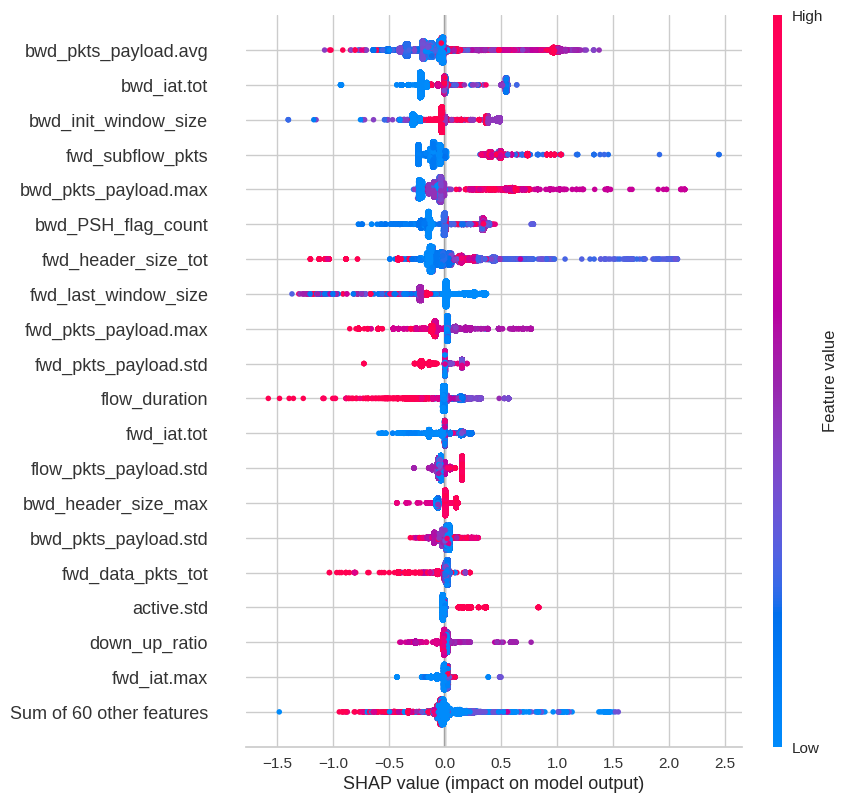

In [59]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bruteforce XML shap

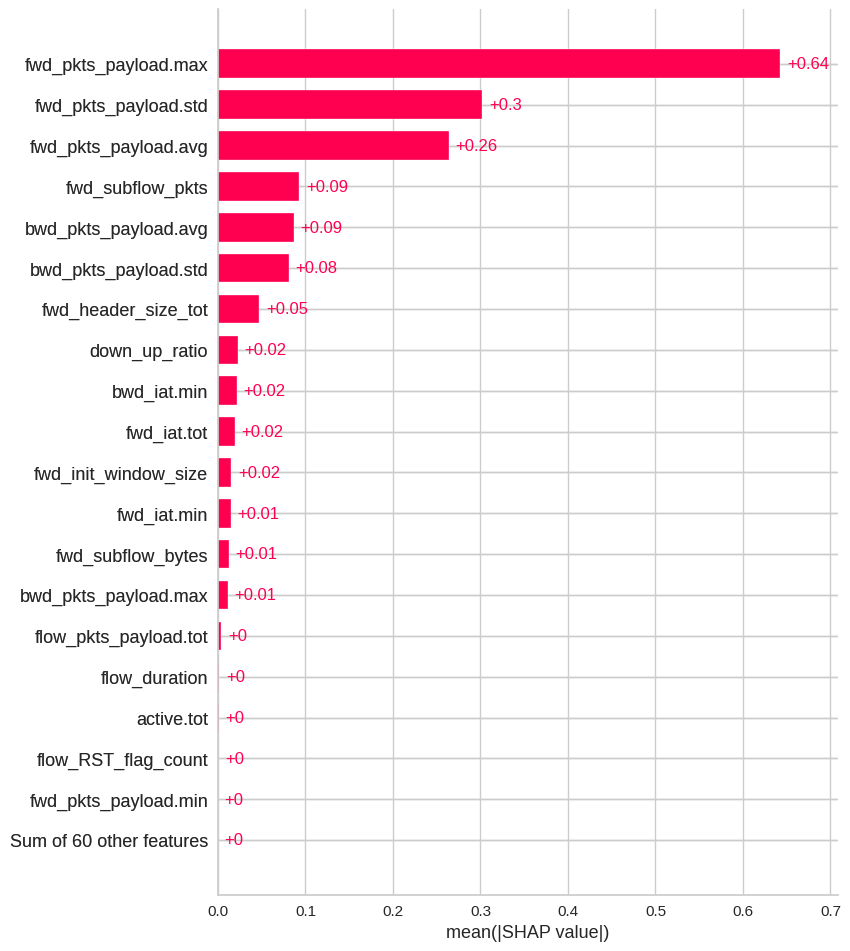

In [60]:
exp = Explanation(sv.values[:,:,2], 
                  sv.base_values[:,2], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

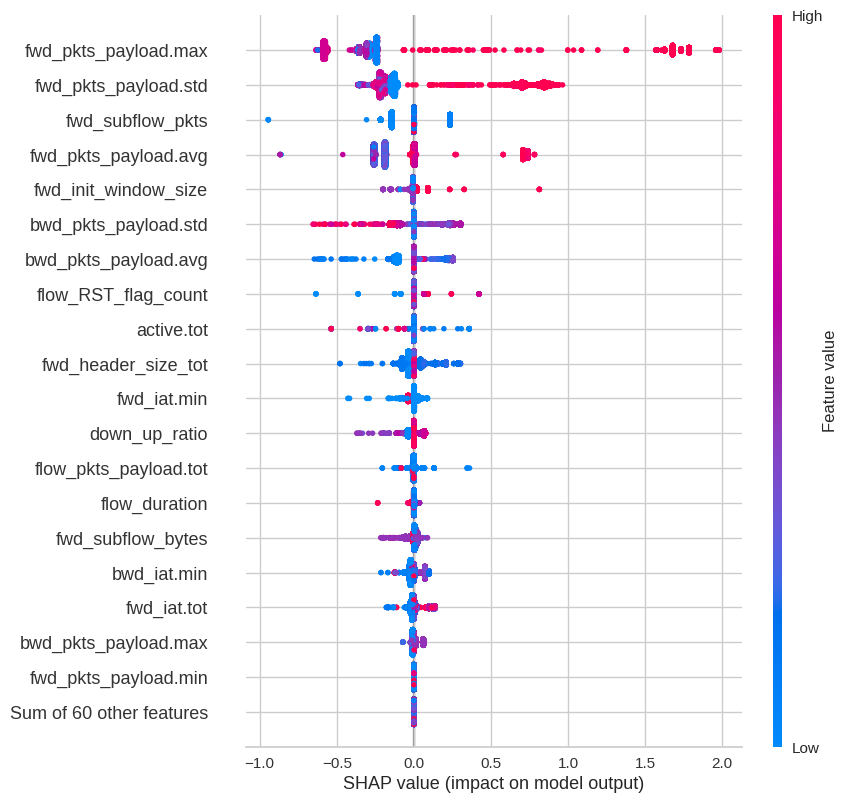

In [61]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

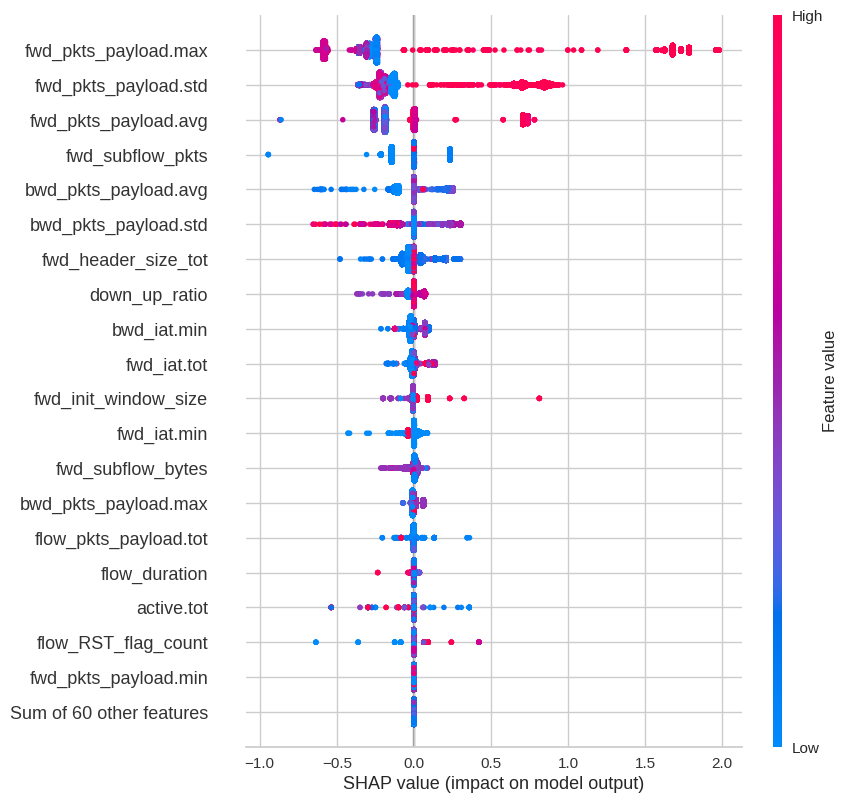

In [62]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Probing shap

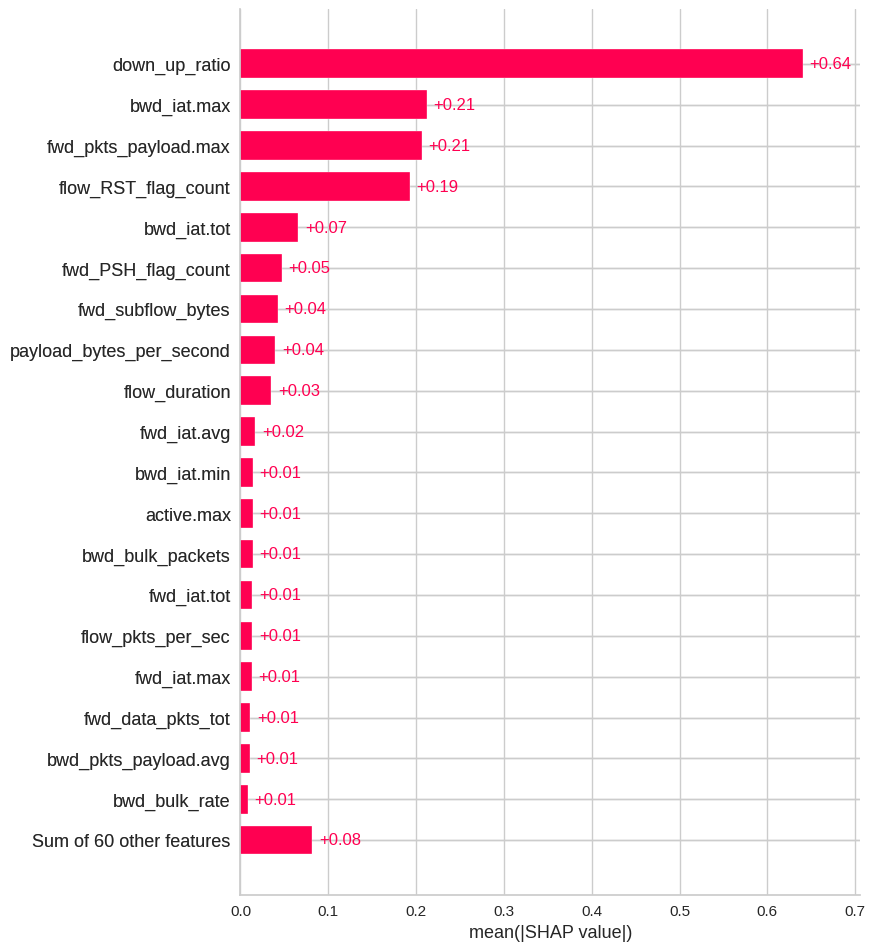

In [63]:
exp = Explanation(sv.values[:,:,3], 
                  sv.base_values[:,3], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

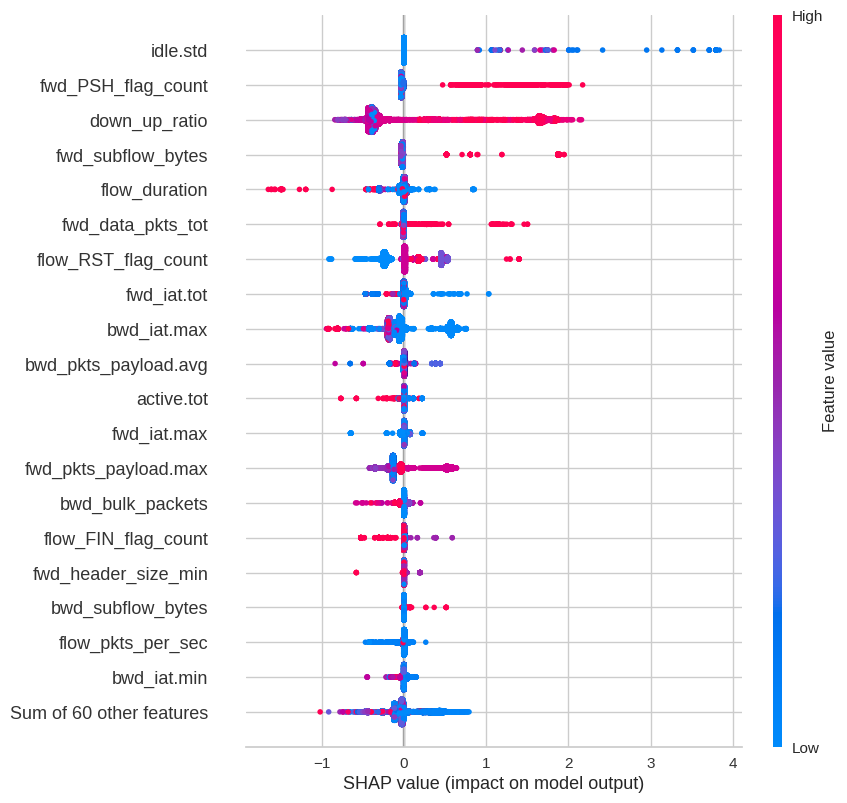

In [64]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

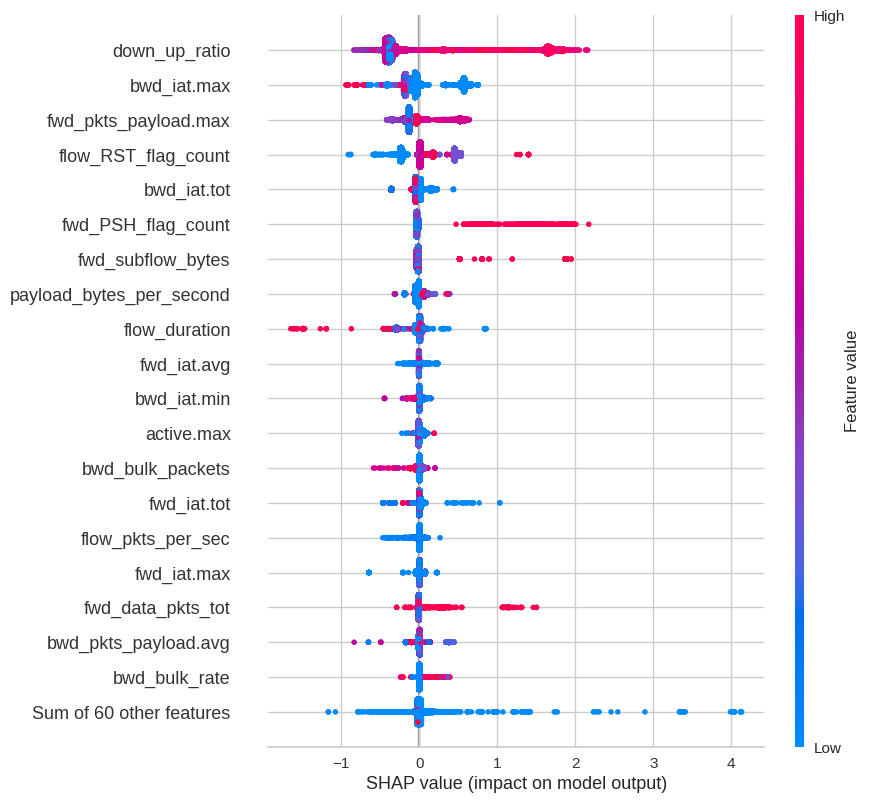

In [65]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Miner shap

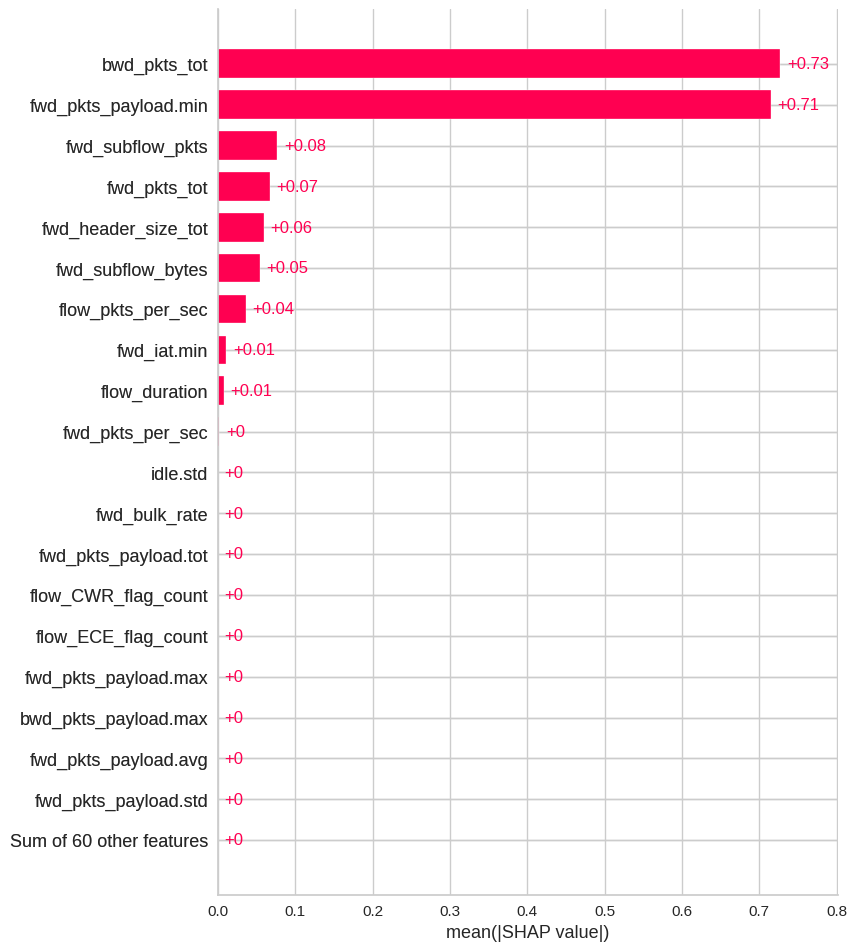

In [66]:
exp = Explanation(sv.values[:,:,4], 
                  sv.base_values[:,4], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

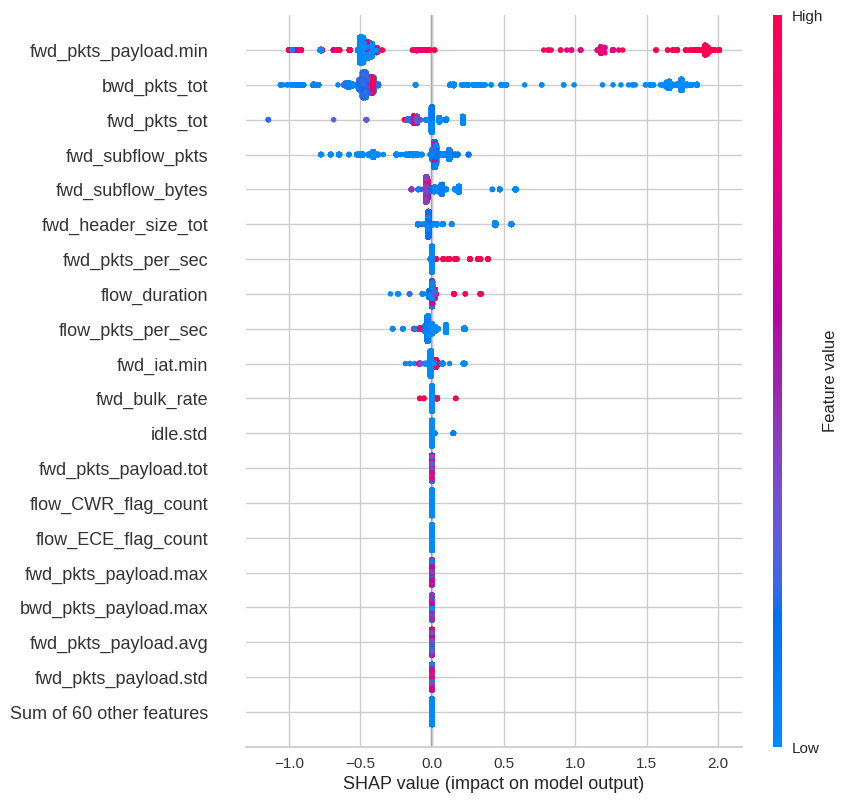

In [67]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

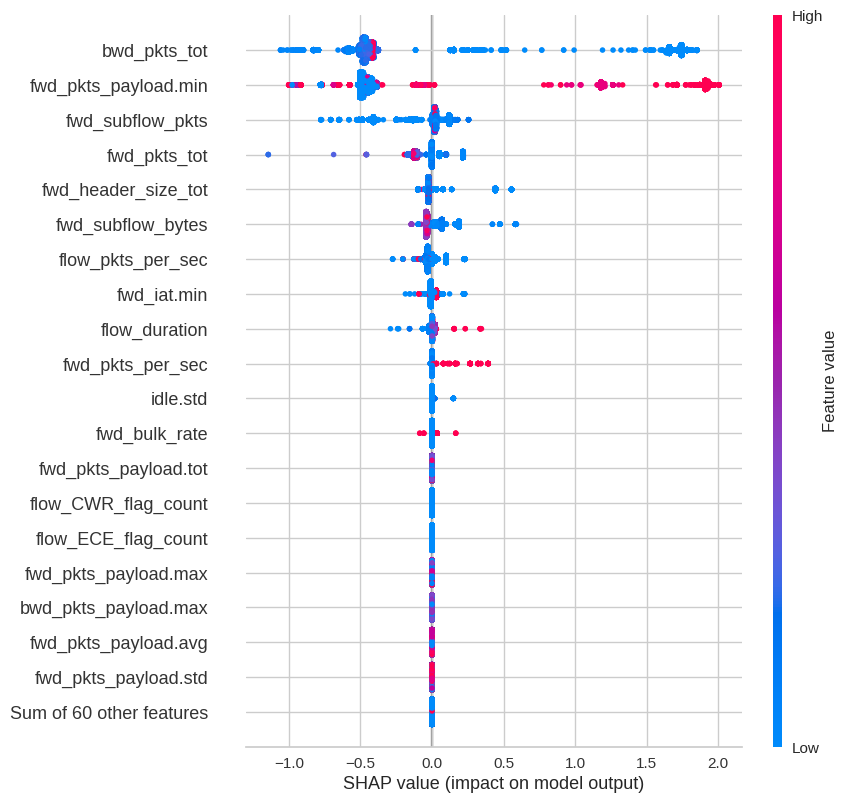

In [68]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

# Zero day test

In [69]:
classes = sorted(pd.unique(ds['traffic_category']).tolist())

In [70]:
removed_class = 2
y_train_attack = y_train[y_train != removed_class]
X_train_attack = X_train[y_train != removed_class]
y_train_attack = np.where(y_train_attack > removed_class, y_train_attack - 1, y_train_attack)
bst.fit(X_train_attack, y_train_attack)
y_predicted_train = bst.predict(X_train_attack)
y_test_attack = np.where(y_test == removed_class, 6, y_test)
y_test_attack = np.where(y_test_attack > removed_class, y_test_attack - 1, y_test_attack)
y_predicted_test = bst.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test_attack, y_predicted_test, 'weighted')

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.965065,0.768403
1,PRECISION,0.967111,0.660884
2,RECALL,0.965065,0.768403
3,F1 SCORE,0.964335,0.702761


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


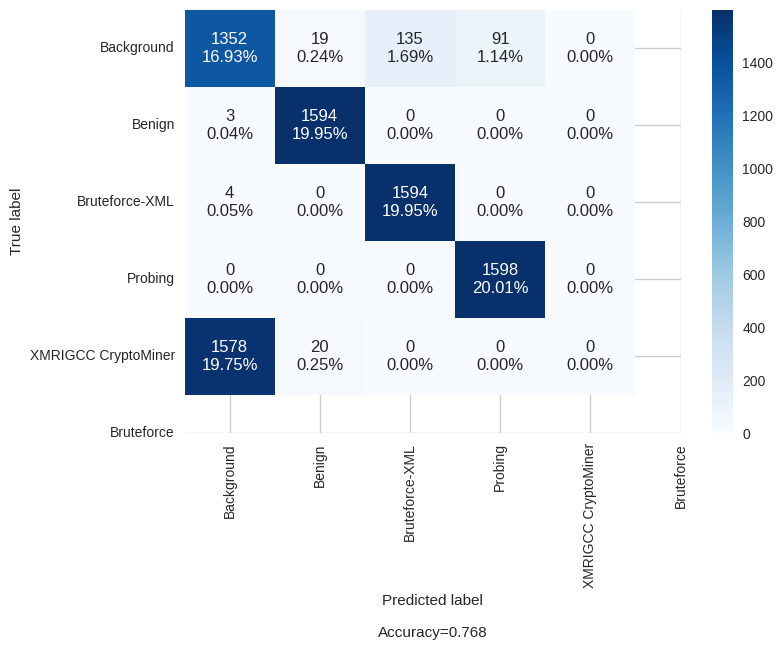

In [71]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test_attack,y_predicted_test)
categories = pd.unique(['Background',
 'Benign',
 'Bruteforce-XML',
 'Probing',
 'XMRIGCC CryptoMiner',
 'Bruteforce'])
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [72]:
removed_class = 3
y_train_attack = y_train[y_train != removed_class]
X_train_attack = X_train[y_train != removed_class]
y_train_attack = np.where(y_train_attack > removed_class, y_train_attack - 1, y_train_attack)
bst.fit(X_train_attack, y_train_attack)
y_predicted_train = bst.predict(X_train_attack)
y_test_attack = np.where(y_test == removed_class, 6, y_test)
y_test_attack = np.where(y_test_attack > removed_class, y_test_attack - 1, y_test_attack)
y_predicted_test = bst.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test_attack, y_predicted_test, 'weighted')

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.984039,0.783175
1,PRECISION,0.984584,0.680231
2,RECALL,0.984039,0.783175
3,F1 SCORE,0.983932,0.717586


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


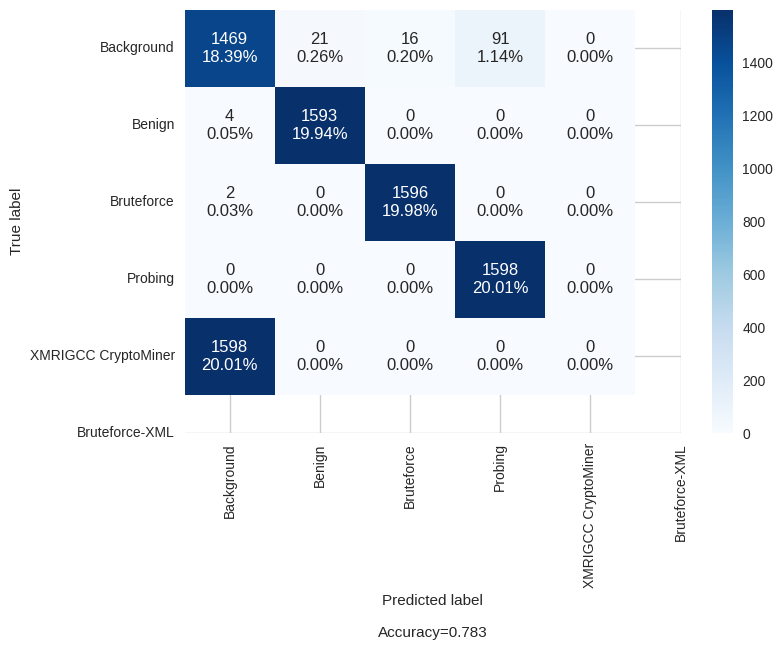

In [73]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test_attack,y_predicted_test)
categories = pd.unique(['Background',
 'Benign',
 'Bruteforce',
 'Probing',
 'XMRIGCC CryptoMiner',
 'Bruteforce-XML'])
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [74]:
removed_class = 4
y_train_attack = y_train[y_train != removed_class]
X_train_attack = X_train[y_train != removed_class]
y_train_attack = np.where(y_train_attack > removed_class, y_train_attack - 1, y_train_attack)
bst.fit(X_train_attack, y_train_attack)
y_predicted_train = bst.predict(X_train_attack)
y_test_attack = np.where(y_test == removed_class, 6, y_test)
y_test_attack = np.where(y_test_attack > removed_class, y_test_attack - 1, y_test_attack)
y_predicted_test = bst.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test_attack, y_predicted_test, 'weighted')

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.975393,0.777166
1,PRECISION,0.976918,0.674219
2,RECALL,0.975393,0.777166
3,F1 SCORE,0.975184,0.712182


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


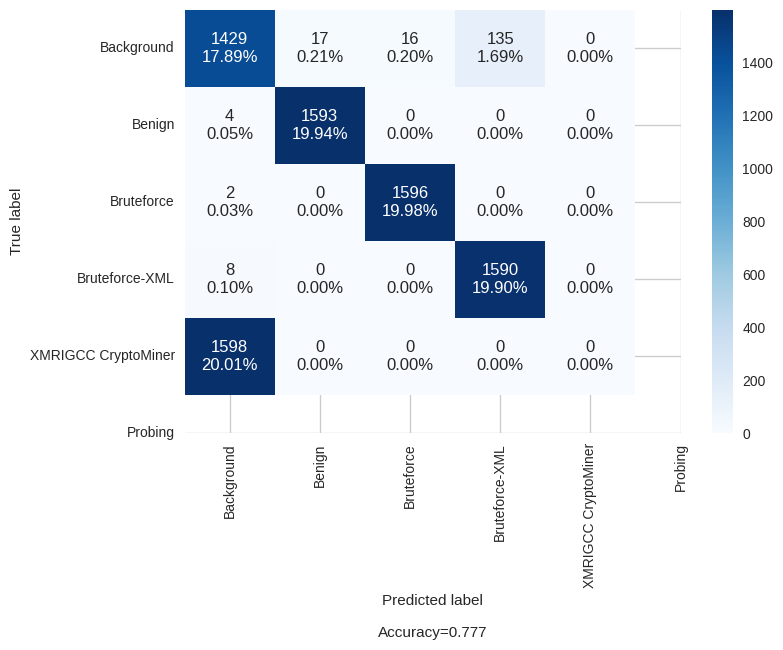

In [75]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test_attack,y_predicted_test)
categories = pd.unique(['Background',
 'Benign',
 'Bruteforce',
 'Bruteforce-XML',
 'XMRIGCC CryptoMiner',
 'Probing'])
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [76]:
removed_class = 5
y_train_attack = y_train[y_train != removed_class]
X_train_attack = X_train[y_train != removed_class]
y_train_attack = np.where(y_train_attack > removed_class, y_train_attack - 1, y_train_attack)
bst.fit(X_train_attack, y_train_attack)
y_predicted_train = bst.predict(X_train_attack)
y_test_attack = np.where(y_test == removed_class, 6, y_test)
y_test_attack = np.where(y_test_attack > removed_class, y_test_attack - 1, y_test_attack)
y_predicted_test = bst.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test_attack, y_predicted_test, 'weighted')

,Measure,Train,Test
0,ACCURACY,0.970737,0.966074
1,PRECISION,0.972318,0.967647
2,RECALL,0.970737,0.966074
3,F1 SCORE,0.970057,0.965166


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


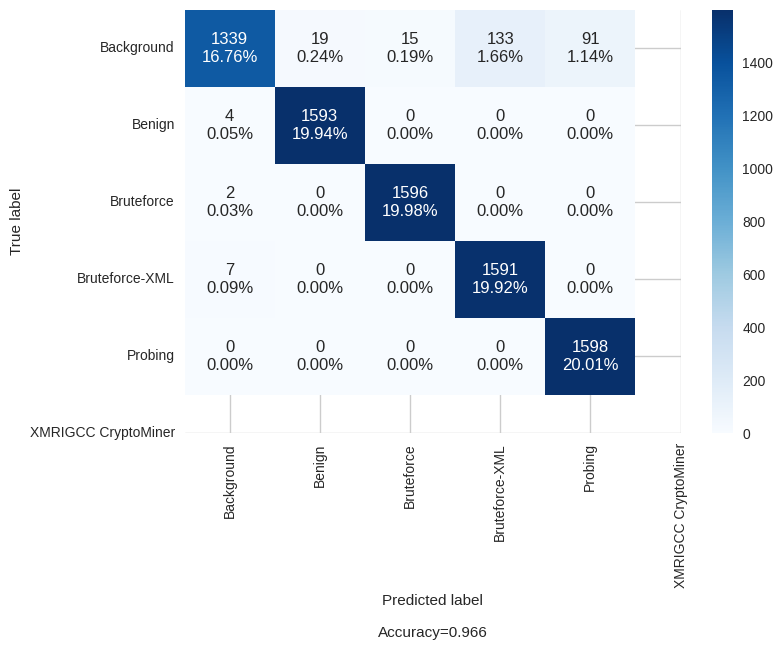

In [77]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test_attack,y_predicted_test)
categories = pd.unique(['Background',
 'Benign',
 'Bruteforce',
 'Bruteforce-XML',
 'Probing',
 'XMRIGCC CryptoMiner'])
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')